=== Modèle : Isolation Forest ===

=== Rapport pour Isolation Forest ===
              precision    recall  f1-score   support

           0       0.15      0.66      0.24     29192
           1       0.34      0.04      0.08    119015

    accuracy                           0.16    148207
   macro avg       0.24      0.35      0.16    148207
weighted avg       0.30      0.16      0.11    148207



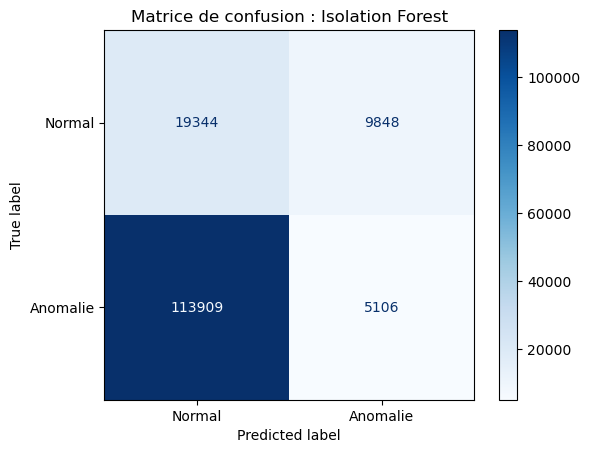

Taux de faux positifs : 0.34
Taux de faux négatifs : 0.96
=== Modèle : PCA Robuste ===

=== Rapport pour PCA Robuste ===
              precision    recall  f1-score   support

           0       0.21      0.94      0.34     29192
           1       0.89      0.11      0.20    119015

    accuracy                           0.28    148207
   macro avg       0.55      0.53      0.27    148207
weighted avg       0.76      0.28      0.23    148207



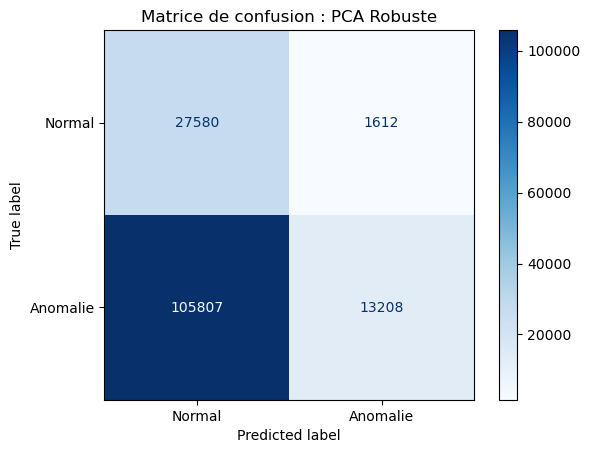

Taux de faux positifs : 0.06
Taux de faux négatifs : 0.89
=== Modèle : Local Outlier Factor ===


C:\Users\elton\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\elton\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\elton\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\elton\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 370, in _score
    response_method = _check_response_method(estimator, self._response_method)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, make_scorer, f1_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt

# === Étape 1 : Chargement des données ===
file_path = "D:\\MEMO\\dataset\\archive\\kddcup.data_10_percent.gz"
columns = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins",
    "logged_in", "num_compromised", "root_shell", "su_attempted",
    "num_root", "num_file_creations", "num_shells", "num_access_files",
    "num_outbound_cmds", "is_host_login", "is_guest_login", "count",
    "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate",
    "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate",
    "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate",
    "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
    "dst_host_srv_serror_rate", "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate", "label"
]
data = pd.read_csv(file_path, header=None, names=columns, compression='gzip')

# Ajouter une colonne pour étiqueter les anomalies (1 pour anomalie, 0 pour normal)
data["is_anomaly"] = data["label"].apply(lambda x: 0 if x == "normal." else 1)

# Séparation des caractéristiques et de la cible
X = data.drop(columns=["label", "is_anomaly"])
y = data["is_anomaly"]

# Encodage des colonnes catégorielles
categorical_features = ["protocol_type", "service", "flag"]
numeric_features = X.columns.difference(categorical_features)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

X_preprocessed = preprocessor.fit_transform(X)

# === Étape 3 : Séparation des données ===
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.3, random_state=42)

# === Fonction utilitaire pour évaluer les modèles ===
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n=== Rapport pour {model_name} ===")
    print(classification_report(y_true, y_pred))

    # Matrice de confusion
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomalie"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Matrice de confusion : {model_name}")
    plt.show()

    # Métriques supplémentaires
    fp = cm[0, 1]  # Faux positifs
    fn = cm[1, 0]  # Faux négatifs
    print(f"Taux de faux positifs : {fp / (fp + cm[0, 0]):.2f}")
    print(f"Taux de faux négatifs : {fn / (fn + cm[1, 1]):.2f}")

# === Étape 4 : Modèles ===

# 1. Isolation Forest avec GridSearchCV pour l'ajustement des hyperparamètres
print("=== Modèle : Isolation Forest ===")
param_grid = {
    'contamination': [0.05, 0.1, 0.15],
    'n_estimators': [100, 200],
    'max_samples': ['auto', 0.8, 0.9]
}
iso_forest = IsolationForest(random_state=42, n_jobs=-1)
grid_search_iso = GridSearchCV(iso_forest, param_grid, scoring=make_scorer(f1_score, average='macro'), cv=3)
grid_search_iso.fit(X_train, y_train)
best_iso_forest = grid_search_iso.best_estimator_
y_pred_iso = best_iso_forest.predict(X_test)
y_pred_iso = np.where(y_pred_iso == 1, 0, 1)  # Convertir : 1 -> Normal, -1 -> Anomalie
evaluate_model(y_test, y_pred_iso, "Isolation Forest")

# 2. PCA Robuste
print("=== Modèle : PCA Robuste ===")
pca = PCA(n_components=2)
pca_features_train = pca.fit_transform(X_train)
pca_features_test = pca.transform(X_test)
pca_scores = np.linalg.norm(pca_features_test, axis=1)
threshold = np.percentile(pca_scores, 90)  # Seuil à 90% des scores
y_pred_pca = (pca_scores > threshold).astype(int)
evaluate_model(y_test, y_pred_pca, "PCA Robuste")

# 3. Local Outlier Factor (LOF) avec GridSearchCV pour l'ajustement des hyperparamètres
print("=== Modèle : Local Outlier Factor ===")
param_grid = {
    'n_neighbors': [10, 20, 30],
    'contamination': [0.05, 0.1, 0.15]
}
lof = LocalOutlierFactor(n_jobs=-1)
grid_search_lof = GridSearchCV(lof, param_grid, scoring=make_scorer(f1_score, average='macro'), cv=3)
grid_search_lof.fit(X_train, y_train)
best_lof = grid_search_lof.best_estimator_
y_pred_lof = best_lof.fit_predict(X_test)
y_pred_lof = np.where(y_pred_lof == 1, 0, 1)  # Convertir : 1 -> Normal, -1 -> Anomalie
evaluate_model(y_test, y_pred_lof, "Local Outlier Factor")
